# Load libraries

In [1]:
import pickle
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from joblib import load
from treeinterpreter import treeinterpreter as ti
from sklearn.inspection import permutation_importance
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# Define general variables

In [2]:
seed = 0
only_these_labels = [16, 92, 53, 88, 65, 6] 
number_experiment = 18
tmpLocal = "/home/leo/Desktop/thesis/work/thesis/"
max_elements_per_class = 15000

# Get own model predictions

In [3]:
# load model
a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/ownModel/OwnModel" + str(number_experiment) +"Predictions.pkl", "rb")
ownModelResults = pickle.load(a_file)
print(ownModelResults.keys())
print(ownModelResults["trainIds"].shape)

dict_keys(['trainIds', 'trainLabels', 'trainPredictions', 'validIds', 'validLabels', 'validPredictions', 'testIds', 'testLabels', 'testPredictions'])
(52360,)


# Get RF predictions

In [4]:
# load files
a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/RF/predictionsRF.pkl", "rb")
rFResults = pickle.load(a_file)
print(rFResults.keys())
print(rFResults["trainPredictions"].shape)

dict_keys(['trainIds', 'trainLabels', 'trainPredictions', 'validIds', 'validLabels', 'validPredictions', 'testIds', 'testLabels', 'testPredictions'])
(52360,)


# Test if test datasets are equals

In [5]:
assert np.array_equal(ownModelResults["testIds"], rFResults["testIds"])
print("test ok: ids in train dataset used in own model are the same in RF")

test ok: ids in train dataset used in own model are the same in RF


In [6]:
assert np.array_equal(ownModelResults["testLabels"], rFResults["testLabels"])
print("test ok: labels in train dataset used in own model are the same in RF")

test ok: labels in train dataset used in own model are the same in RF


In [7]:
assert not np.array_equal(ownModelResults["testPredictions"], rFResults["testPredictions"])
print("test ok: predictions of own model and RF are differente in test")

test ok: predictions of own model and RF are differente in test


# Analysis

# get confusion matrix

In [19]:
# ["true", "pred", "all", None]
normalize = "true"
# normalize = None



RF model


<AxesSubplot:>

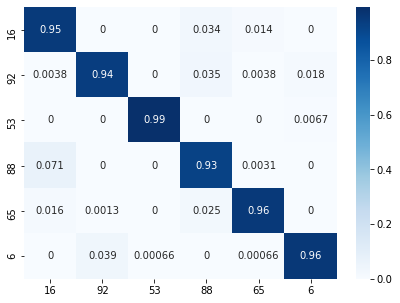

In [20]:
print("RF model")

# get confussion matrix
# C_ij such that  is equal to the number of observations known to be in group i and predicted to be in group j
rFResultsCM = confusion_matrix(
    rFResults["testLabels"], 
    rFResults["testPredictions"], 
    normalize = normalize
)

# print(f"class 0: {rFResultsCM[0, :]}")

fig0, ax = plt.subplots(figsize = (7,5))

# plot
sn.heatmap(
    rFResultsCM, 
    annot=True, 
    ax = ax,
    yticklabels=only_these_labels,
    xticklabels=only_these_labels,
    cmap=plt.cm.Blues,
)

In [35]:
# fig0.savefig("confussionMatrixRF.pdf", bbox_inches='tight')

Own model
class 0: [0.72413793 0.04827586 0.06896552 0.06206897 0.07586207 0.02068966]


<AxesSubplot:>

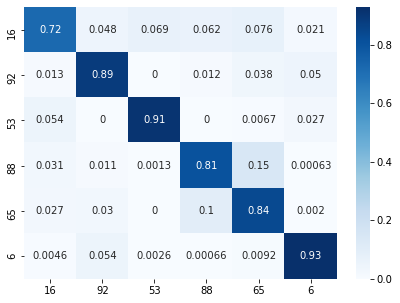

In [33]:
print("Own model")

# get confussion matrix
# C_ij such that  is equal to the number of observations known to be in group i and predicted to be in group j
ownModelCM = confusion_matrix(ownModelResults["testLabels"], ownModelResults["testPredictions"], normalize = normalize)

print(f"class 0: {ownModelCM[0, :]}")

fig1, ax = plt.subplots(figsize = (7,5))

# plot
sn.heatmap(
    ownModelCM, 
    annot=True,
    ax = ax,
    yticklabels=only_these_labels,
    xticklabels=only_these_labels,
    cmap=plt.cm.Blues,
)

In [34]:
# fig1.savefig("confussionMatrixOM.pdf", bbox_inches='tight')

Text(0.5, 1.0, 'Modelo propuesto')

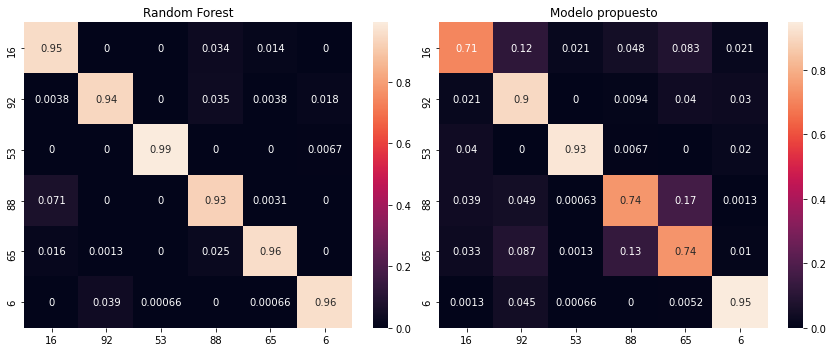

In [11]:
fig, axs = plt.subplots(ncols=2, tight_layout = True, figsize = (12,5))
sn.heatmap(rFResultsCM, annot=True, ax=axs[0], yticklabels=only_these_labels,xticklabels=only_these_labels)
axs[0].set_title("Random Forest")
sn.heatmap(ownModelCM, annot=True, ax=axs[1],  yticklabels=only_these_labels,xticklabels=only_these_labels)
axs[1].set_title("Modelo propuesto")

In [12]:
# fig.savefig("confussionMatrixRFOM.pdf", bbox_inches='tight')

# Get classification report

In [13]:
print("RF model")
print(classification_report(rFResults["testLabels"], rFResults["testPredictions"]))

RF model
              precision    recall  f1-score   support

         6.0       0.49      0.95      0.65       145
        16.0       0.96      0.94      0.95      1593
        53.0       0.99      0.99      0.99       149
        65.0       0.94      0.93      0.93      1598
        88.0       0.99      0.96      0.97      1537
        92.0       0.98      0.96      0.97      1524

    accuracy                           0.95      6546
   macro avg       0.89      0.95      0.91      6546
weighted avg       0.96      0.95      0.95      6546



In [14]:
print("own model")
print(classification_report(ownModelResults["testLabels"], ownModelResults["testPredictions"]))

own model
              precision    recall  f1-score   support

         6.0       0.40      0.71      0.51       145
        16.0       0.83      0.90      0.86      1593
        53.0       0.95      0.93      0.94       149
        65.0       0.84      0.74      0.79      1598
        88.0       0.76      0.74      0.75      1537
        92.0       0.95      0.95      0.95      1524

    accuracy                           0.83      6546
   macro avg       0.79      0.83      0.80      6546
weighted avg       0.84      0.83      0.83      6546



# Get how many correct and wrong classifications are done by each model?
Add this to the paper

In [9]:

# save correct classifications by each model 
# shape: (classes, models (2: own and RF))
correctClassifications = np.zeros(shape  = (6, 2))

wrongClassifications = np.zeros(shape = (6,2))

# iterate by each class
for i in np.arange(6):
    
    # RF
    correctClassifications[i][0] = rFResultsCM[i][i] / np.sum(rFResultsCM[i])
    wrongClassifications[i][0] = np.sum(rFResultsCM[i][np.delete(np.arange(6), i)]) / np.sum(rFResultsCM[i])
    
    # own model
    correctClassifications[i][1] = ownModelCM[i][i] / np.sum(ownModelCM[i])
    wrongClassifications[i][1] = np.sum(ownModelCM[i][np.delete(np.arange(6), i)]) / np.sum(ownModelCM[i])

NameError: name 'rFResultsCM' is not defined

In [44]:
print("Correct classifications. 0: RF")
correctClassifications

Correct classifications. 0: RF


array([[0.95172414, 0.72413793],
       [0.9391086 , 0.88826114],
       [0.99328859, 0.91275168],
       [0.9261577 , 0.80851064],
       [0.95770982, 0.84059857],
       [0.95931759, 0.92913386]])

In all classes, RF is better

In [45]:
print("Wrong classifications. 0: RF")
wrongClassifications

Wrong classifications. 0: RF


array([[0.04827586, 0.27586207],
       [0.0608914 , 0.11173886],
       [0.00671141, 0.08724832],
       [0.0738423 , 0.19148936],
       [0.04229018, 0.15940143],
       [0.04068241, 0.07086614]])

In all classes, RF is better

Based on resutls, RF is better in all classes. There is no one class our model is better, so the models are not complementaries. Our model does not add more value to the classification.

# Get examples wrongly classified by own model but correctly by RF

In [8]:
# get RF samples who predictions are equals to labels
maskRFCorrects = (rFResults["testPredictions"] == rFResults["testLabels"])

# get OM samples who predictions are not equals to labels
maskOwnModelWrong = (ownModelResults["testPredictions"] != ownModelResults["testLabels"])

# get ids that 1)RF are corrects 2) ON are wrong
finalMask = (maskRFCorrects & maskOwnModelWrong)

# get ids samples
idsRFCorrectsAndOwnModelWrongs = ownModelResults["testIds"][finalMask]
labelsRFCorrectsAndOwnModelWrongs = ownModelResults["testLabels"][finalMask]

# # build object
# samplesRFCorrectsAndOwnModelWrongs = {
#     "ids": idsRFCorrectsAndOwnModelWrongs,
#     "labels": ownModelResults["testLabels"][finalMask]
# }

In [9]:
labelsRFCorrectsAndOwnModelWrongs.shape

(740,)

In [10]:
# test if RF is correct classified and Own model is wrong
for i in idsRFCorrectsAndOwnModelWrongs:
    
    index = np.where(ownModelResults["testIds"]  == i)[0][0]
    
#     print(index)
    
    # test
    # 1) if RF is classifiying correctly
    # 2) if Own model is classifiying wrongly
    assert ownModelResults["testLabels"][index] == rFResults["testPredictions"][index] and ownModelResults["testLabels"][index] != ownModelResults["testPredictions"][index]

[ 35 132  12 277 220  64]


Text(0.5, 0, 'Clases')

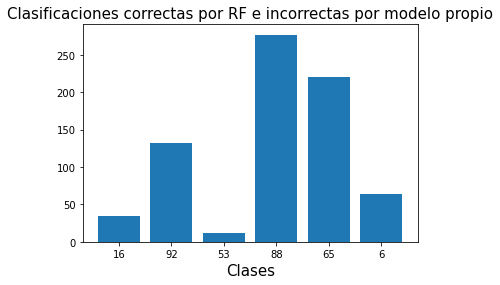

In [11]:
# analyze labels distributions
fig, ax = plt.subplots()

classesOMWCRF, countClassesOMWCRF = np.unique(labelsRFCorrectsAndOwnModelWrongs, return_counts = True)

print(countClassesOMWCRF)

# countClasses = countClasses / np.sum(countClasses)
# countClasses = countClassesOMWCRF

classes = list(map(str, classesOMWCRF))

ax.bar(
    classes, 
    countClassesOMWCRF,
    tick_label = only_these_labels
#     width = 10,
)

# ax.set_title("Samples correct RF and wrong own model")

ax.set_title("Clasificaciones correctas por RF e incorrectas por modelo propio", fontsize = 15)
ax.set_xlabel("Clases", fontsize = 15)

In [12]:
# fig.savefig("classesDistributionRFCorrectOMWrong.pdf", bbox_inches='tight')

# Get examples correctly classified by own model but wrongly by RF

In [13]:
# get RF samples who predictions are not equals to labels
maskRFWrong = rFResults["testPredictions"] != rFResults["testLabels"]

# get OM samples who predictions are equals to labels
maskOwnModelCorrect = ownModelResults["testPredictions"] == ownModelResults["testLabels"]

# get ids that 1)RF are corrects 2) ON are wrong
finalMask = (maskRFWrong & maskOwnModelCorrect)

# get ids samples
idsRFWrongAndOwnModelCorrect = ownModelResults["testIds"][finalMask]
labelsRFWrongsAndOwnModelCorrects = ownModelResults["testLabels"][finalMask]

# # build object
# samplesRFCorrectsAndOwnModelWrongs = {
#     "ids": idsRFCorrectsAndOwnModelWrongs,
#     "labels": ownModelResults["testLabels"][finalMask]
# }

[ 2 51 89 40 18]


Text(0.5, 0, 'Clases')

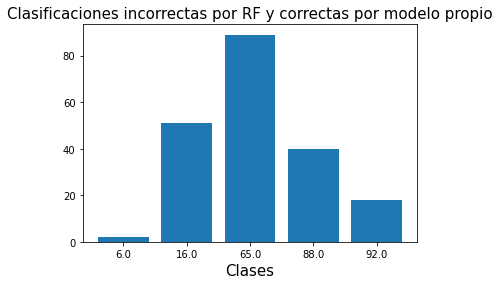

In [14]:
# analyze labels distributions
fig, ax = plt.subplots()

classesOMCWRF, countClassesOMCWRF = np.unique(labelsRFWrongsAndOwnModelCorrects, return_counts = True)

print(countClassesOMCWRF)

# countClasses = countClasses / np.sum(countClasses)
# countClasses = countClasses 

classes = list(map(str, classesOMCWRF))

ax.bar(
    classes, 
    countClassesOMCWRF,
#     tick_label = only_these_labels,
#     width = 10,
)

# ax.set_title("Samples wrong RF and correct own model")
ax.set_title("Clasificaciones incorrectas por RF y correctas por modelo propio", fontsize = 15)
ax.set_xlabel("Clases", fontsize = 15)

# Get examples wrongly classified by own model and wrongly by RF

In [15]:
# get RF samples who predictions are not equals to labels
maskRFWrong = rFResults["testPredictions"] != rFResults["testLabels"]

# get OM samples who predictions are not equals to labels
maskOwnModelWrong = ownModelResults["testPredictions"] != ownModelResults["testLabels"]

# get ids that 1)RF are wrong 2) ON are wrong
finalMask = (maskRFWrong & maskOwnModelWrong)

# get ids samples
idsRFWrongAndOwnModelWrong = ownModelResults["testIds"][finalMask]
labelsRFWrongsAndOwnModelWrong = ownModelResults["testLabels"][finalMask]

# # build object
# samplesRFCorrectsAndOwnModelWrongs = {
#     "ids": idsRFCorrectsAndOwnModelWrongs,
#     "labels": ownModelResults["testLabels"][finalMask]
# }

[ 5 46  1 29 25 44]


Text(0.5, 0, 'Clases')

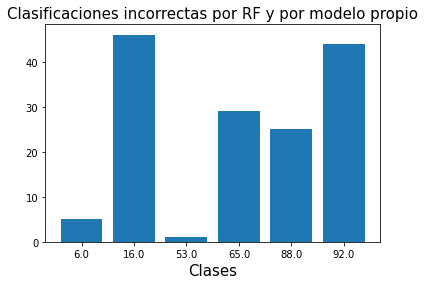

In [16]:
# analyze labels distributions
fig, ax = plt.subplots()

classesOMWWRF, countClassesOMWWRF = np.unique(labelsRFWrongsAndOwnModelWrong, return_counts = True)

print(countClassesOMWWRF)

# countClasses = countClasses / np.sum(countClasses)
# countClasses = countClasses 

classes = list(map(str, classesOMWWRF))

ax.bar(
    classes, 
    countClassesOMWWRF,
#     tick_label = only_these_labels,
#     width = 10,
)

# ax.set_title("Samples wrong RF and correct own model")
ax.set_title("Clasificaciones incorrectas por RF y por modelo propio", fontsize = 15)
ax.set_xlabel("Clases", fontsize = 15)

# Get samples correctly by RF and own model

In [17]:
# get RF samples who predictions are equals to labels
maskRFCorrect = rFResults["testPredictions"] == rFResults["testLabels"]

# get OM samples who predictions are equals to labels
maskOwnModelCorrect = ownModelResults["testPredictions"] == ownModelResults["testLabels"]

# get ids that 1)RF are wrong 2) ON are wrong
finalMask = (maskRFCorrect & maskOwnModelCorrect)

# get ids samples
idsRFCorrectAndOwnModelCorrect = ownModelResults["testIds"][finalMask]
labelsRFCorrectAndOwnModelCorrect = ownModelResults["testLabels"][finalMask]

# # build object
# samplesRFCorrectsAndOwnModelWrongs = {
#     "ids": idsRFCorrectsAndOwnModelWrongs,
#     "labels": ownModelResults["testLabels"][finalMask]
# }

[ 103 1364  136 1203 1252 1398]


Text(0.5, 0, 'Clases')

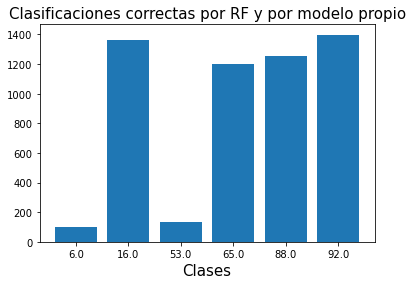

In [18]:
# analyze labels distributions
fig, ax = plt.subplots()

classesOMCCRF, countClassesOMCCRF = np.unique(labelsRFCorrectAndOwnModelCorrect, return_counts = True)

print(countClassesOMCCRF)

# countClasses = countClasses / np.sum(countClasses)
# countClasses = countClasses 

classes = list(map(str, classesOMCCRF))

ax.bar(
    classes, 
    countClassesOMCCRF,
#     tick_label = only_these_labels,
#     width = 10,
)

# ax.set_title("Samples wrong RF and correct own model")
ax.set_title("Clasificaciones correctas por RF y por modelo propio", fontsize = 15)
ax.set_xlabel("Clases", fontsize = 15)

# Get samples correctly by own model

In [19]:
# get OM samples who predictions are equals to labels
maskOwnModelCorrect = ownModelResults["testPredictions"] == ownModelResults["testLabels"]

# get ids that 1)RF are wrong 2) ON are wrong
finalMask = (maskOwnModelCorrect)

# get ids samples
idsOwnModelCorrect = ownModelResults["testIds"][finalMask]
labelsOwnModelCorrect = ownModelResults["testLabels"][finalMask]

# # build object
# samplesRFCorrectsAndOwnModelWrongs = {
#     "ids": idsRFCorrectsAndOwnModelWrongs,
#     "labels": ownModelResults["testLabels"][finalMask]
# }

[ 105 1415  136 1292 1292 1416]


Text(0.5, 0, 'Clases')

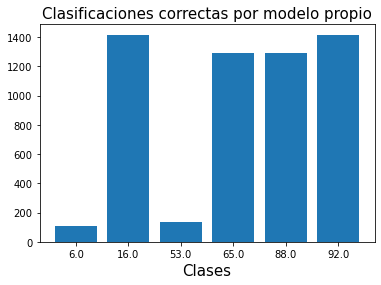

In [20]:
# analyze labels distributions
fig, ax = plt.subplots()

classesOMC, countClassesOMC = np.unique(labelsOwnModelCorrect, return_counts = True)

print(countClassesOMC)

# countClasses = countClasses / np.sum(countClasses)
# countClasses = countClasses 

classes = list(map(str, classesOMC))

ax.bar(
    classes, 
    countClassesOMC,
#     tick_label = only_these_labels,
#     width = 10,
)

# ax.set_title("Samples wrong RF and correct own model")
ax.set_title("Clasificaciones correctas por modelo propio", fontsize = 15)
ax.set_xlabel("Clases", fontsize = 15)

# Get analysis of errors by models

In [21]:
# count label instaces in dataset to make percentages
labelsTmp, totalLabels = np.unique(ownModelResults["testLabels"], return_counts = True)
print(labelsTmp)
print(totalLabels)
print("\n")


print("Rf correct - om wrong")
print(classesOMWCRF)
print(countClassesOMWCRF)
print(np.round(100 * countClassesOMWCRF / totalLabels, 1))
print("\n")


print("Rf wrong - om correct")
print(classesOMCWRF)
print(countClassesOMCWRF)
print(np.round(100 * countClassesOMCWRF / [145, 1593, 1598, 1537, 1524], 1))
print("\n")


print("Rf wrong - om wrong")
print(classesOMWWRF)
print(countClassesOMWWRF)
print(np.round(100 * countClassesOMWWRF / totalLabels, 1))
print("\n")


print("Rf correct - om correct")
print(classesOMCCRF)
print(countClassesOMCCRF)
print(np.round(100 * countClassesOMCCRF / totalLabels, 1))
print("\n")


print("om correct")
print(classesOMC)
print(countClassesOMC)
print(np.round(100 * countClassesOMC / totalLabels, 1))
print("\n")

[ 6. 16. 53. 65. 88. 92.]
[ 145 1593  149 1598 1537 1524]


Rf correct - om wrong
[ 6. 16. 53. 65. 88. 92.]
[ 35 132  12 277 220  64]
[24.1  8.3  8.1 17.3 14.3  4.2]


Rf wrong - om correct
[ 6. 16. 65. 88. 92.]
[ 2 51 89 40 18]
[1.4 3.2 5.6 2.6 1.2]


Rf wrong - om wrong
[ 6. 16. 53. 65. 88. 92.]
[ 5 46  1 29 25 44]
[3.4 2.9 0.7 1.8 1.6 2.9]


Rf correct - om correct
[ 6. 16. 53. 65. 88. 92.]
[ 103 1364  136 1203 1252 1398]
[71.  85.6 91.3 75.3 81.5 91.7]


om correct
[ 6. 16. 53. 65. 88. 92.]
[ 105 1415  136 1292 1292 1416]
[72.4 88.8 91.3 80.9 84.1 92.9]




# Get features RF uses to classify them

In [25]:
# # get RF model
# # # load file
# rf = load('../../experiments/comparingModels/seed' + str(seed) + '/RF/trainedRF.joblib') 

In [26]:
# # loading features names
# seed = 0
# with open(f"../random_forest/ids/seed{seed}/maxClass15k/dataset_ids_before_balancing.pkl", "rb") as f:
#     lc_ids = pickle.load(f)

# with open("../random_forest/features/fats"+str(int(lc_ids["train"][0]))+".pkl", "rb") as f:
#     tmp = load(f)
    
#     # get features names
#     featuresNames = tmp.columns.values

In [22]:
# # FATS computing: https://github.com/isadoranun/FATS/blob/master/FATS/FeatureFunctionLib.py

# # get the most important features
# featuresByImportance, importance = featuresNames[np.argsort(rf.feature_importances_)[::-1]], rf.feature_importances_[np.argsort(rf.feature_importances_)[::-1]]

# featuresToDisplay = 20

# fig, ax = plt.subplots(figsize = (10, 10), tight_layout = True)

# ax.set_title(f"Top {featuresToDisplay} feature importances on Random Forest")
# ax.barh(featuresByImportance[:featuresToDisplay], importance[:featuresToDisplay])
# # ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
# ax.set_yticklabels(featuresByImportance[:featuresToDisplay],fontsize=10, rotation=45)

# Get decomposition of predictions on correct RF and wrong OM

In [28]:
# # (node_indicator, _) = rf.decision_path(instances)

# # node_indicator

# # Extract single tree
# estimator = rf.estimators_
# estimatorIndex = 0
# print(f"number of trees: {len(estimator)}")

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator[estimatorIndex], 
#                 out_file='tree' + str(estimatorIndex) + '.dot', 
#                 feature_names = featuresNames,
#                 class_names = True,
#                 rounded = True, 
#                 proportion = False, 
#                 precision = 2, 
#                 filled = True,
#                 rotate = True,
# )

# # Convert to png
# estimatorIndex = str(estimatorIndex)
# from subprocess import call
# call(['dot', '-Tpng', 'tree' + estimatorIndex + '.dot', '-o', 'tree'  + estimatorIndex + '.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree' + estimatorIndex + '.png')

In [23]:
# # get data
# id_ = idsRFCorrectsAndOwnModelWrongs[1]

# index = np.where(ownModelResults["testIds"]  == id_)[0][0]

# print(f"label: {ownModelResults['testLabels'][index]}")

# print(f"RF prediction: {rFResults['testPredictions'][index]}")

# with open("../random_forest/features/fats"+ str(round(id_)) +".pkl", "rb") as f:
#     instances = load(f)

# #get predictions
# prediction, bias, contributions = ti.predict(rf, instances)

# # prediction = rf.predict(instances)

# only_these_labels = [16, 92, 53, 88, 65, 6]

# print(only_these_labels[np.argmax(prediction)])

In [30]:
# print(prediction)

# print(np.argmax(prediction))

[[0.20052328 0.09406491 0.00284883 0.02324763 0.670528   0.00878735]]
4


In [24]:
# # get decomposition
# for i in range(len(instances)):
    
#     print("Instance", i)
#     print("Bias (trainset mean", bias[i])
#     print("Feature contributions:")
# #     for c, feature in sorted(zip(contributions[i], featuresNames), key=lambda x: -abs(x[0])):
# #         print(feature, round(c, 2))
#     for c, feature in zip(contributions[0], 
#                              featuresNames):
#         print(feature)
#         print(c)
        
#     print("-"*20)

In [32]:
# ti.predict?

# Feature importance permutation analysis

In [51]:
# get RF model
# # load file
rf = load('../../experiments/comparingModels/seed' + str(seed) + '/RF/trainedRF.joblib') 

In [52]:
# loading features names
seed = 0
with open(f"../random_forest/ids/seed{seed}/maxClass15k/dataset_ids_before_balancing.pkl", "rb") as f:
    lc_ids = pickle.load(f)

with open("../random_forest/features/fats"+str(int(lc_ids["train"][0]))+".pkl", "rb") as f:
    tmp = load(f)
    
    # get features names
    featuresNames = tmp.columns.values

# by classes

In [53]:
idsRFCorrectsAndOwnModelWrongs.shape

(740,)

In [59]:
# get features of RF corrects and own modelo wrong.

# get features
features = {}
labels = {}

# get ids to analyze

# get all classes
classesToAnalyze = only_these_labels

for classToAnalyze in classesToAnalyze:
    
    print(f"class {classToAnalyze}")
    
    # 1) ids with RF correct and RF wrong
    # get ids of class
    selectedIds = idsRFCorrectsAndOwnModelWrongs[labelsRFCorrectsAndOwnModelWrongs == classToAnalyze]
    
    # save features of selected ids
    tmp = []
    
    # get data
    for lc_id in selectedIds:

        with open("../random_forest/features/fats"+str(int(lc_id))+".pkl", "rb") as f:
            tmp.append(load(f))

    # transform list to numpy array
    tmp = np.array(tmp, dtype = "float").reshape(len(tmp),-1)
    
    # clean data
    
    # get rows without inf values
    mask = ~(np.isinf(tmp).any(axis=1))
    
    # get rows without nan values
    mask2 = ~(np.isnan(tmp).any(axis = 1))

    # print(mask2.shape)
    # print(mask.shape)

    # get clean features data
    features_ = tmp[mask & mask2]
    
    # get clean labels
    labels_ = labelsRFCorrectsAndOwnModelWrongs[labelsRFCorrectsAndOwnModelWrongs == classToAnalyze][mask & mask2]

    print(f"features shape (# light curves, features): {features_.shape}")
    print(labels_.shape)


    # save class arrays into final dict (class: arrays) 
    features[classToAnalyze] = features_
    labels[classToAnalyze] = labels_

class 16
features shape (# light curves, features): (126, 288)
(126,)
class 92
features shape (# light curves, features): (55, 288)
(55,)
class 53
features shape (# light curves, features): (11, 288)
(11,)
class 88
features shape (# light curves, features): (209, 288)
(209,)
class 65
features shape (# light curves, features): (273, 288)
(273,)
class 6
features shape (# light curves, features): (33, 288)
(33,)


In [60]:
print(features.keys())

dict_keys([16, 92, 53, 88, 65, 6])


In [61]:
# this is doing a permutation analisis by class.
# It receives all the features of the RF correct and OM incorrect and compute the importance in the trained model

# save permutation by class
permutationImportancesClasses = {}

for classToAnalyze in classesToAnalyze:
    
    print(f"class: {classToAnalyze}")
    print(f"features: {labels[classToAnalyze].shape}")
    
    # get permutation importances
    # this receives the rf trained model, features (dic by class) and its labels (dic by class)
    r = permutation_importance(
                        rf, 
                        features[classToAnalyze], 
                        labels[classToAnalyze],
                        n_repeats=10,
                        random_state=0,
                        n_jobs = 4,
    )
    
    # save permutation by class
    permutationImportancesClasses[classToAnalyze] = r

class: 16
features: (126,)
class: 92
features: (55,)
class: 53
features: (11,)
class: 88
features: (209,)
class: 65
features: (273,)
class: 6
features: (33,)


In [62]:
# # save file
# a_file = open("./importancePermutationTestByClass.pkl", "wb")
# pickle.dump(permutationImportancesClasses, a_file)
# a_file.close()

In [63]:
# save permutations results
# save object
a_file = open("./importancePermutationTestByClass.pkl", "rb")
permutationImportancesClasses = pickle.load(a_file)

In [64]:
# a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/ownModel/testOwnModelPredictions.pkl", "rb")
# ownModelResults = pickle.load(a_file)

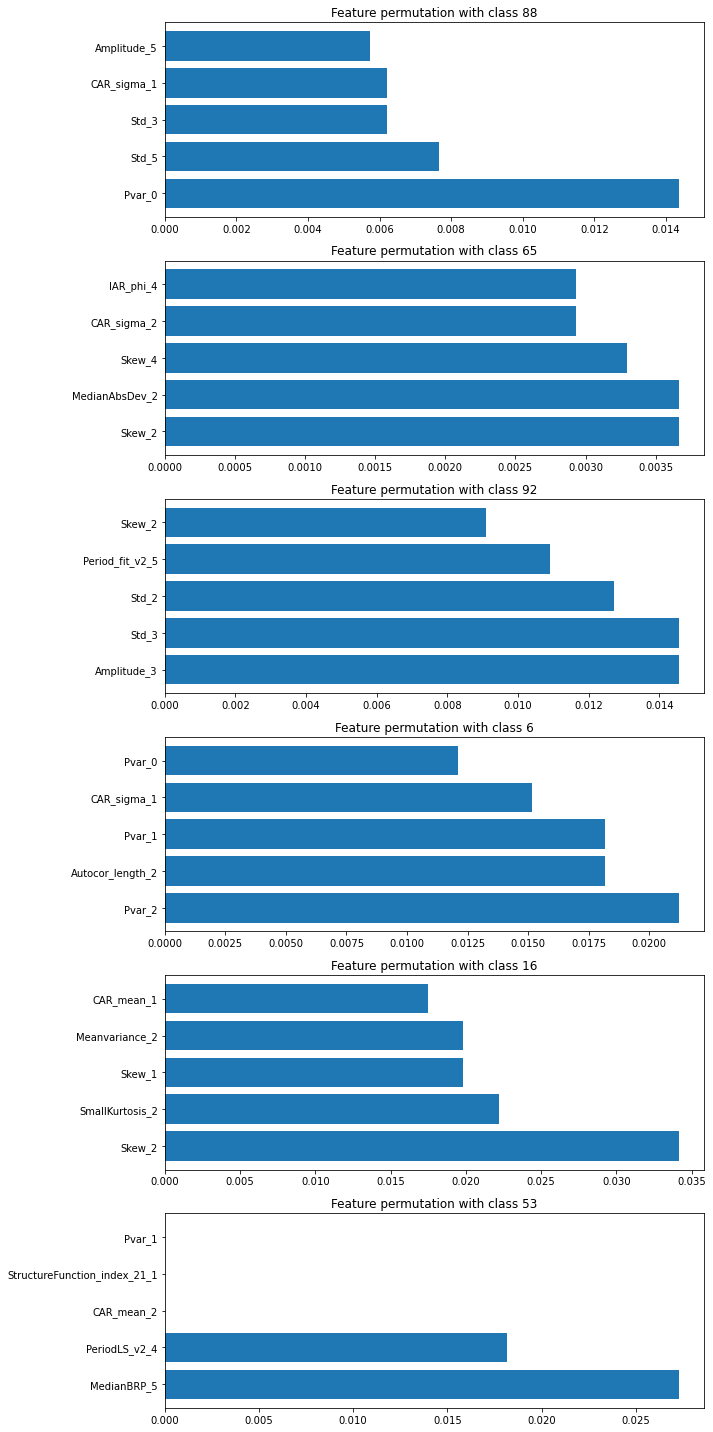

In [68]:
# do plot
fig, ax = plt.subplots(len(classesToAnalyze), 1, figsize = (10, 20), tight_layout = True)

maxIndex = 5

# classesToAnalyze = [65, 16, 88, 92, 6, 53]
classesToAnalyze = [88, 65, 92, 6, 16, 53]

# each class
for i, class_ in enumerate(classesToAnalyze):
    
    # get sorted feautres
    idxFeatures = permutationImportancesClasses[class_].importances_mean.argsort()[::-1][:maxIndex]
    
#     print(idxFeatures.shape)
#     print(permutationImportancesClasses[class_].importances_mean[idxFeatures])
    
    ax[i].set_title(f"Feature permutation with class {class_}")
    ax[i].barh(
        featuresNames[idxFeatures], 
        permutationImportancesClasses[class_].importances_mean[idxFeatures],
    )
#     # ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
#     ax[i].set_yticklabels(featuresNames[:maxIndex],fontsize=10, rotation=45)


In [69]:
fig.savefig("featureImportancePermutation.pdf", bbox_inches='tight')

# full dataset

In [68]:
# 1) ids with RF correct and RF wrong
features_ = []

# get data
for lc_id in idsRFCorrectsAndOwnModelWrongs:

    with open("../random_forest/features/fats"+str(int(lc_id))+".pkl", "rb") as f:
        features_.append(load(f))

features_ = np.array(features_, dtype = "float").reshape(len(features_),-1)

# print(features_.shape)

# clean data

# get rows without inf values
mask = ~(np.isinf(features_).any(axis=1))

mask2 = ~(np.isnan(features_).any(axis = 1))

# print(mask2.shape)
# print(mask.shape)

features = features_[mask & mask2]
labels = labelsRFCorrectsAndOwnModelWrongs[mask & mask2]

print(features.shape)
print(labels.shape)

(948, 288)
(948,)


In [69]:
 # get permutation importances
r = permutation_importance(
                    rf, 
                    features, 
                    labels,
                    n_repeats=10,
                    random_state=0,
                    n_jobs = 4,
)

# save file
a_file = open("./importancePermutationTestAllClasses.pkl", "wb")
pickle.dump(r, a_file)
a_file.close()

<BarContainer object of 10 artists>

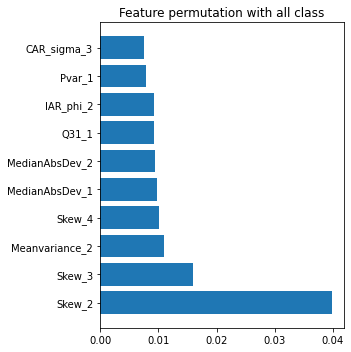

In [70]:
# do plot
fig, ax = plt.subplots(figsize = (5, 5), tight_layout = True)

maxIndex = 10

# get sorted feautres
idxFeatures = r.importances_mean.argsort()[::-1][:maxIndex]

ax.set_title(f"Feature permutation with all class")
ax.barh(
    featuresNames[idxFeatures], 
    r.importances_mean[idxFeatures],
)
#     # ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
#     ax[i].set_yticklabels(featuresNames[:maxIndex],fontsize=10, rotation=45)


# Analizing what model is the best one

In [4]:
plt.rcParams.update({
    "text.usetex": True,
})

18
test
acc: 0.88 +/- 0.014
f1 macro: 0.84 +/- 0.014
recall: 0.87 +/- 0.014
precision: 0.83 +/- 0.0139
f1 macro:
[16, 92, 53, 88, 65, 6]
[0.9  0.94 0.94 0.85 0.87 0.55]
[0.007 0.005 0.022 0.023 0.021 0.041]


rf
test
acc: 0.95 +/- 0.001
f1 macro: 0.91 +/- 0.001
recall: 0.95 +/- 0.002
precision: 0.89 +/- 0.00164
f1 macro:
[16, 92, 53, 88, 65, 6]
[0.95 0.97 0.99 0.97 0.93 0.64]
[0.002 0.002 0.003 0.001 0.001 0.008]




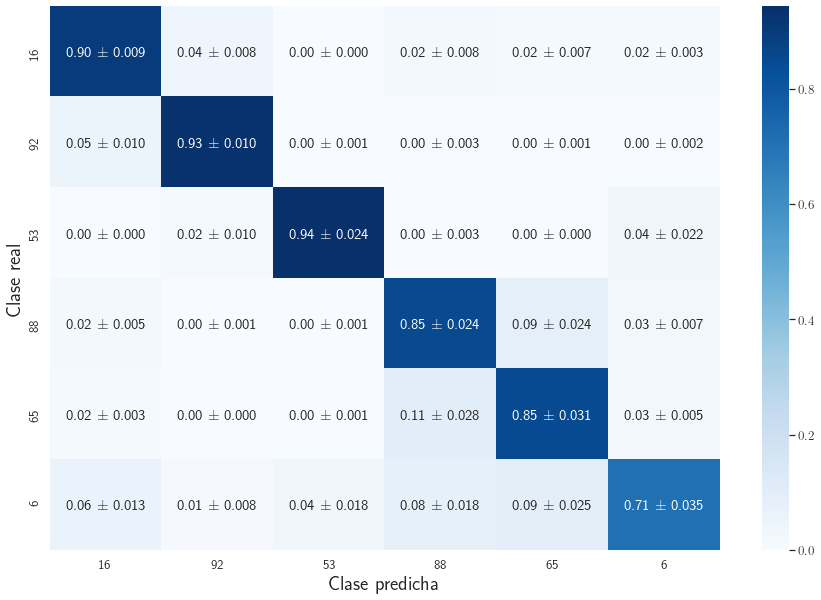

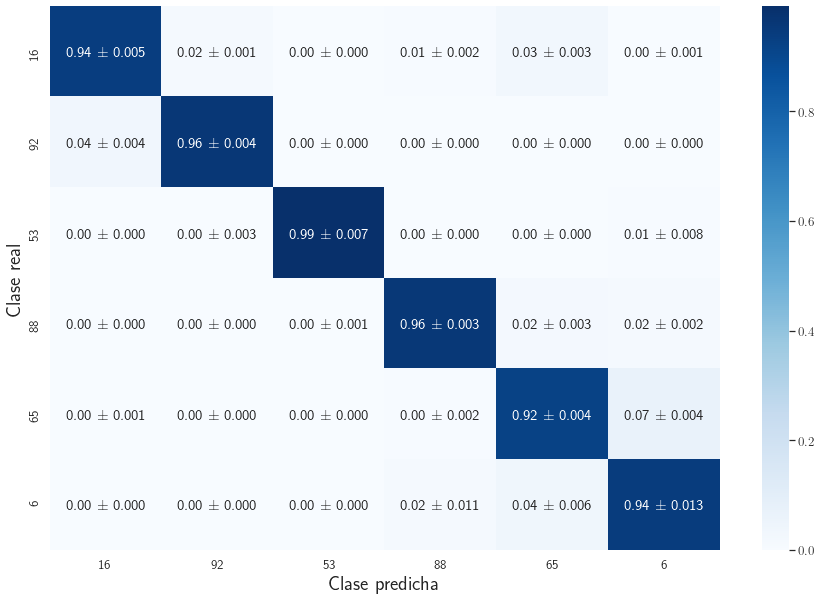

In [23]:
# modelsToAnalize = [17, 18, 19, 20]
# modelsToAnalize = [22, 23, 24, 25, 26, 20, 18]
modelsToAnalize = [18, "rf"]
seeds = [0,1,2, 3]
# seeds = [0, 1,2,3,4]
# seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8]


tmpLocal = "/home/leo/Desktop/thesis/work/thesis/"
max_elements_per_class = 15000

accArray = np.zeros(shape = (len(modelsToAnalize), len(seeds)))
f1MacroArray = np.zeros(shape = (len(modelsToAnalize), len(seeds)))
f1WeightedArray = np.zeros(shape = (len(modelsToAnalize), len(seeds)))
f1Array = np.zeros(shape = (len(modelsToAnalize), len(seeds), len(only_these_labels), ))
recallArray = np.zeros(shape = (len(modelsToAnalize), len(seeds)))
precisionArray = np.zeros(shape = (len(modelsToAnalize), len(seeds)))
cmArray = np.zeros(shape = (len(modelsToAnalize), len(only_these_labels), len(only_these_labels), len(seeds)))

for idxExp, number_experiment in enumerate(modelsToAnalize):
    
#     accTmp = 0
#     f1Macro = 0
#     f1Weighted = 0
    
#     accArray = np.zeros(shape = (len(seeds), ))
#     f1MacroArray = np.zeros(shape = (len(seeds), ))
#     f1WeightedArray = np.zeros(shape = (len(seeds), ))

#     f1Array = np.zeros(shape = (len(seeds), len(only_these_labels), ))
    
    print(number_experiment)
    
#     for subset in ["train", "valid", "test"]:

#     for subset in ["valid"]:
    for subset in ["test"]:
        
        print(subset)
        
        for idxSeed, seed in enumerate(seeds):

#             print(f"{number_experiment} + seed + {seed}


            
            
            ######## plot training loss and f1 score

            
            

            # path to load data
#             expPath = "experiments/" + str(number_experiment) + "/seed" + str(seed) + "/maxClass" + str(int(max_elements_per_class/1000)) + "k"
#             folder_path = (tmpLocal + expPath)


#             losses = pd.read_csv(folder_path + "/training_losses.csv")

#             # f1 scores
#             # f1Scores = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass15k" + "/f1Scores.csv")
#             f1Scores = pd.read_csv(folder_path + "/f1Scores.csv")

#             # plot losses
#             fig, ax = plt.subplots(1, 2, figsize = (10,4), tight_layout = True)

#             maxPlot = 3000

#             # loss
#             ax[0].set_xlabel("N° epoch")
#             ax[0].set_ylabel("Loss")
#             ax[0].plot(losses.iloc[:maxPlot, 0], label = "train")
#             ax[0].plot(losses.iloc[:maxPlot, 1], label = "validation")
#             ax[0].legend()
#             ax[0].set_title(f"exp:{number_experiment} ")

#             # f1 scores
#             ax[1].set_xlabel("N° epoch")
#             ax[1].set_ylabel("F1 score")
#             ax[1].plot(f1Scores.iloc[:maxPlot])





             ############ load results

            if number_experiment != "rf":

#                 a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/ownModel/OwnModel" + str(number_experiment) +"Predictions.pkl", "rb")
                
                
                try:
                    
                    a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/ownModel/OwnModel" + str(number_experiment) +"Predictions.pkl", "rb")
#                     print("ok")
                except:
                       
                    print(f"no file seed {seed}, exp {number_experiment}")
                    
                    seed_ = 0
                        
                    a_file = open("../../experiments/comparingModels/seed" + str(seed_) + "/ownModel/OwnModel" + str(number_experiment) +"Predictions.pkl", "rb")
                    
#                     continue
             
            # RF
            else:
                
#                 try:
                    
                a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/RF/predictionsRF.pkl", "rb")
#                 except:
                       
#                     print("no file")
                    
#                     pass
                    
            ownModelResultsTmp = pickle.load(a_file)



            
            ################# confussion matrix
    
    
    
    
            # get confussion matrix
            # C_ij such that  is equal to the number of observations known to be in group i and predicted to be in group j
            cmResults = confusion_matrix(
                ownModelResultsTmp[subset + "Labels"], 
                ownModelResultsTmp[subset + "Predictions"], 
                labels = only_these_labels,
#                 normalize = "pred",
                normalize = "true",
#                 normalize = "all",
            )
    
#             print(rFResultsCM)
#             print(f"class 0: {rFResultsCM[0, :]}")
            cmArray[idxExp, :, :, idxSeed] = cmResults
        
#             fig0, ax = plt.subplots(figsize = (7,5))

# #             # plot
#             sn.heatmap(
#                 cmArray, 
#                 annot=True, 
#                 ax = ax,
#                 yticklabels=only_these_labels,
#                 xticklabels=only_these_labels,
#                 cmap=plt.cm.Blues,
#             )
            
    
    

            ############ get classification report


    #         print(classification_report(
    #             ownModelResultsTmp["validLabels"], 
    #             ownModelResultsTmp["validPredictions"],
    #             labels = only_these_labels,
    #         ))





            ############### compute metrics


            # to compute mean accuracy (by seeds)
            accArray[idxExp, idxSeed] = accuracy_score(
                ownModelResultsTmp[subset + "Labels"], 
                ownModelResultsTmp[subset + "Predictions"]
            )

            f1MacroArray[idxExp, idxSeed] = f1_score(
                ownModelResultsTmp[subset + "Labels"], 
                ownModelResultsTmp[subset + "Predictions"], 
                average='macro',
            )

            f1Array[idxExp, idxSeed, :] = f1_score(
                ownModelResultsTmp[subset + "Labels"], 
                ownModelResultsTmp[subset + "Predictions"], 
                average=None,
                labels = only_these_labels,
            )


    #         f1WeightedArray[idxExp, idxSeed] += f1_score(
    #             ownModelResultsTmp["validLabels"], 
    #             ownModelResultsTmp["validPredictions"], 
    #             average='weighted'
    #         )



            # to compute mean recall (by seeds)
            recallArray[idxExp, idxSeed] = recall_score(
                ownModelResultsTmp[subset + "Labels"], 
                ownModelResultsTmp[subset + "Predictions"],
                average='macro',
            )

            # to compute mean precision (by seeds)
            precisionArray[idxExp, idxSeed] = precision_score(
                ownModelResultsTmp[subset + "Labels"], 
                ownModelResultsTmp[subset + "Predictions"],
                average='macro',
            )





        ######################## average metrics by seed
        
        print(f"acc: {np.mean(accArray[idxExp, :]):.2f} +/- {np.std(accArray[idxExp, :]):.3f}")

        print(f"f1 macro: {np.mean(f1MacroArray[idxExp, :]):.2f} +/- {np.std(f1MacroArray[idxExp, :]):.3f}")

        print(f"recall: {np.mean(recallArray[idxExp, :]):.2f} +/- {np.std(recallArray[idxExp, :]):.3f}")

        print(f"precision: {np.mean(precisionArray[idxExp, :]):.2f} +/- {np.std(precisionArray[idxExp, :]):.3}")

    #     print(f"f1 macro: {np.mean(f1MacroArray):.2f} +/- {np.std(f1MacroArray):.2f}")

    #     print(f"f1 weighted: {np.mean(f1WeightedArray):.2f} +/- {np.std(f1WeightedArray):.2f} ")

        print("f1 macro:")
        print(only_these_labels)
        print(np.around(np.mean(f1Array[idxExp, :], axis = 0) , 2))
        print(np.round(np.std(f1Array[idxExp, :], axis = 0), 3))

        
        # confussion matrix
#         print("confussion matrix building")
#         print(np.around(np.mean(cmArray[idxExp, :, :, :], axis = -1), 2))
#         print(np.around(np.std(cmArray[idxExp, :, :, :], axis = -1), 3))
#         print(np.around(np.mean(cmArray[idxExp, :], axis = 0) , 2))
#         print(cmArray)
        
        mtmp = np.mean(cmArray[idxExp, :, :, :], axis = -1)
        mtmpStd = np.std(cmArray[idxExp, :, :, :], axis = -1)
        
#         print(mtmp.shape)
        
        mtmpC = np.chararray(shape = (6, 6), itemsize = 16)
        
        for i in np.arange(6):
            
            for j in np.arange(6):
                
                mtmpC[i, j] = "%.2f" % mtmp[i, j] + " $\pm$ " + "%.3f" % mtmpStd[i, j]
#                 mtmpC[i, j] = r'val $\pm$ std'
#                 mtmpC[i, j] = str("%f" % mtmp[i, j])
#                 mtmpC[i, j] = "hola"
                
#         print("CHARACTERS")
#         print(mtmpC)
                
#         confussion matrix plot
        fig0, ax = plt.subplots(figsize = (15, 10))
               
        sn.set(font_scale = 1.2)       
        
        sn.heatmap(
            mtmp, 
            annot= mtmpC.decode("utf-8"), 
#             fmt="s",
            fmt="s",
            ax = ax,
            yticklabels=only_these_labels,
            xticklabels=only_these_labels,
            cmap=plt.cm.Blues,
            annot_kws = {"size": 15}
        )
             
        plt.ylabel("Clase real", fontsize = 20)
        plt.xlabel("Clase predicha", fontsize = 20)
        
        
        fig0.savefig("confMatrix" + str(number_experiment) + ".pdf", bbox_inches='tight')
        
        print("\n")


    
# print(accArray.shape)    

# ######################## box plots


# fig, ax = plt.subplots(4, 1, tight_layout = True, figsize = (7, 10))

# labels = [0, 1, 2, 3, 4, 5, "Todos"]

# # accuracy
# ax[0].boxplot(
#     np.transpose(accArray), 
# #     labels = ["Incluye error", "Sin error"],
#     labels = labels,
#     showmeans = True,
# #     notch = True,
# #     autorange = True,
# #     manage_ticks = True,
# ) 
# ax[0].set_title("Precisión por experimento", fontsize = 20)

# # f1 macro
# ax[1].boxplot(
#     np.transpose(f1MacroArray), 
#     labels = labels,
# #     labels = ["Incluye error", "Sin error"],
#     showmeans = True,
# ) 
# ax[1].set_title("F1 macro por experimento", fontsize = 20)

# # # f1 weighted
# # ax[2].boxplot(
# #     np.transpose(f1WeightedArray), 
# #     labels = ["Incluye error", "Sin error"],
# #     showmeans = True,
# # ) 

# # ax[2].set_title("F1 weighted por experimento", fontsize = 20)

# # recall macro
# ax[2].boxplot(
#     np.transpose(recallArray), 
#     labels = labels,
# #     labels = ["Incluye error", "Sin error"],
#     showmeans = True,
# ) 
# ax[2].set_title("Recall macro por experimento", fontsize = 20)

# # precision macro
# ax[3].boxplot(
#     np.transpose(precisionArray), 
#     labels = labels,
# #     labels = ["Incluye error", "Sin error"],
#     showmeans = True,
# ) 
# ax[3].set_title("Precision macro por experimento", fontsize = 20)

In [23]:
#fig.savefig("metricsErrorAnalis.pdf", bbox_inches='tight')

In [47]:
accArray

array([[0.5526356 , 0.55110772, 0.52880061],
       [0.78915202, 0.77616501, 0.78044309],
       [0.82826585, 0.85668449, 0.84950344],
       [0.80809778, 0.80336134, 0.81191749],
       [0.77922078, 0.78166539, 0.77524828],
       [0.68770053, 0.71000764, 0.70343774],
       [0.85240642, 0.8921314 , 0.86676853]])

In [51]:
accArray.shape

(7, 3)

In [48]:
f1MacroArray

array([[0.43715823, 0.45177202, 0.43234657],
       [0.65816874, 0.65203607, 0.65499021],
       [0.73841477, 0.77324097, 0.76165282],
       [0.75493628, 0.75362935, 0.75881546],
       [0.76247641, 0.75559827, 0.75433566],
       [0.68483228, 0.70221701, 0.69022705],
       [0.8203399 , 0.8478227 , 0.82230447]])

In [49]:
recallArray

array([[0.45299448, 0.49203175, 0.46868868],
       [0.70402821, 0.70379479, 0.70613816],
       [0.78326742, 0.7986637 , 0.80610921],
       [0.78883592, 0.78283503, 0.80344201],
       [0.7775039 , 0.7930775 , 0.78863709],
       [0.71344513, 0.72507104, 0.73290258],
       [0.84062524, 0.85975475, 0.84926101]])

In [50]:
precisionArray

array([[0.46138006, 0.4898954 , 0.47495919],
       [0.64846808, 0.64572953, 0.65014564],
       [0.723644  , 0.759547  , 0.74635384],
       [0.74315874, 0.73902123, 0.7428534 ],
       [0.75117799, 0.7407549 , 0.73921014],
       [0.67071923, 0.694885  , 0.67637496],
       [0.80751785, 0.83971678, 0.80785136]])

In [46]:
from scipy.stats import wilcoxon

for name, array in zip(["acc", "f1 macro", "recall macro", "prec macro"], [accArray, f1MacroArray, recallArray, precisionArray]):
    
    print(name)
    
    print(array.shape)
    
    # based on this example: https://towardsdatascience.com/wilcoxon-test-in-r-how-to-compare-2-groups-under-the-non-normality-assumption-6fb7f9e92400
    stat, p = wilcoxon(
        array[6,:], 
        array[0,:], 
#         alternative ="less",
        alternative ="greater",
    )

    print(p)
    
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')
    
    print("\n")

acc
(7, 3)
0.125
Statistics=6.000, p=0.125
Same distribution (fail to reject H0)


f1 macro
(7, 3)
0.125
Statistics=6.000, p=0.125
Same distribution (fail to reject H0)


recall macro
(7, 3)
0.125
Statistics=6.000, p=0.125
Same distribution (fail to reject H0)


prec macro
(7, 3)
0.125
Statistics=6.000, p=0.125
Same distribution (fail to reject H0)




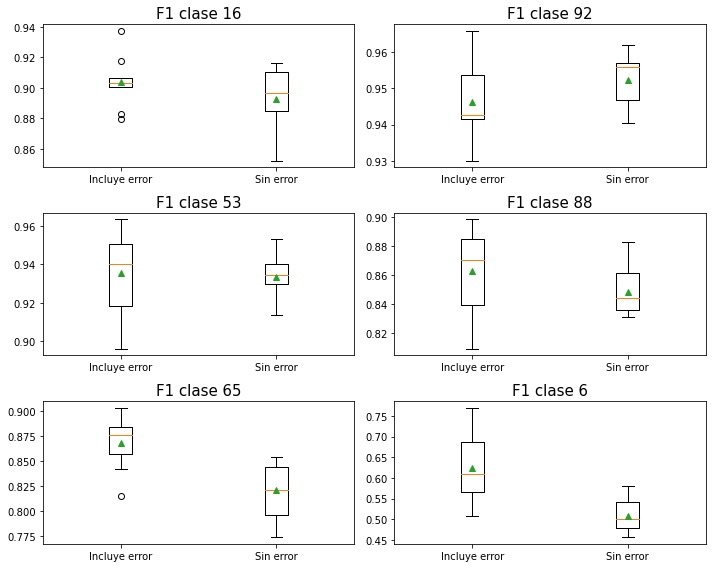

In [11]:
fig, ax = plt.subplots(3, 2,  tight_layout = True, figsize = (10, 8))

index = 0

for i in np.arange(len(only_these_labels)):
# for k in np.arange(2):
    
#     for j in np.arange(3):
        
#         print(f"j: {j}")
#         print(f"k: {k}")
        
#         i = j + k
        # I don't know how to do it better
        if i == 0:
            j,k = 0, 0
        elif i == 1:
            j,k = 0, 1
        elif i == 2:
            j,k = 1, 0
        elif i == 3:
            j,k = 1, 1
        elif i == 4:
            j,k = 2, 0
        elif i == 5:
            j,k = 2, 1
        
#         print(f"i: {i}")
        
#         print(k + 2*j)
#         ax[i].boxplot(
            
        ax[j, k].boxplot(
            np.transpose(f1Array[:, :, i]), 
            labels = ["Incluye error", "Sin error"],
            showmeans = True,
        ) 

#         ax[i].set_title(f"F1 clase {only_these_labels[i]}", fontsize = 15)
        ax[j, k].set_title(f"F1 clase {only_these_labels[i]}", fontsize = 15)

In [12]:
fig.savefig("metricsErrorAnalisByClass.pdf", bbox_inches='tight')

Text(0.5, 1.0, 'Valores de F1 en validación')

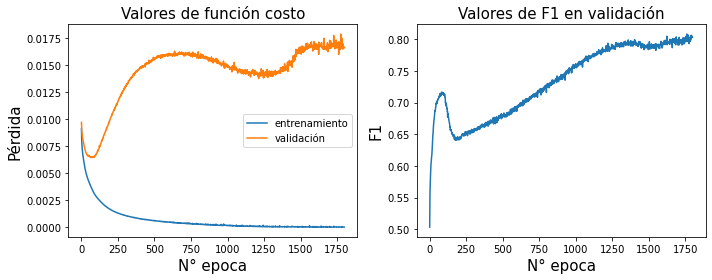

In [7]:
# training plotb

number_experiment = 17
seed = 0

# path to load data
expPath = "experiments/" + str(number_experiment) + "/seed" + str(seed) + "/maxClass" + str(int(max_elements_per_class/1000)) + "k"
folder_path = (tmpLocal + expPath)


######## plot training loss and f1 score

losses = pd.read_csv(folder_path + "/training_losses.csv")

# f1 scores
# f1Scores = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass15k" + "/f1Scores.csv")
f1Scores = pd.read_csv(folder_path + "/f1Scores.csv")

# plot losses
fig, ax = plt.subplots(1, 2, figsize = (10,4), tight_layout = True)

maxPlot = 1800

# loss
ax[0].set_xlabel("N° epoca",  fontsize = 15)
ax[0].set_ylabel("Pérdida",  fontsize = 15)
ax[0].plot(losses.iloc[:maxPlot, 0], label = "entrenamiento")
ax[0].plot(losses.iloc[:maxPlot, 1], label = "validación")
ax[0].legend()
ax[0].set_title(f"Valores de función costo", fontsize = 15)

# f1 scores
ax[1].set_xlabel("N° epoca",  fontsize = 15)
ax[1].set_ylabel("F1",  fontsize = 15)
ax[1].plot(f1Scores.iloc[:maxPlot])
ax[1].set_title(f"Valores de F1 en validación", fontsize = 15)

In [21]:
fig.savefig("trainingBestModel.pdf", bbox_inches='tight')

# test to analize statistically differenciate between metrics

In [49]:
# from scipy.stats import wilcoxon

In [ ]:
# wilcoxon()

# Get metrics own model and RF on train, validation and test

In [8]:
seed = 0
number_experiment = 17

In [9]:
# load model
a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/ownModel/OwnModel" + str(number_experiment) +"Predictions.pkl", "rb")
ownModelResults = pickle.load(a_file)
print(ownModelResults.keys())
print(ownModelResults["trainIds"].shape)

dict_keys(['trainIds', 'trainLabels', 'trainPredictions', 'validIds', 'validLabels', 'validPredictions', 'testIds', 'testLabels', 'testPredictions'])
(52360,)


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

subsets = ["train", "valid", "test"]

for subset in subsets:
    
    print(subset)
    
    # RF
    print("RF")
    print(
        classification_report(
            rFResults[subset + "Labels"], 
            rFResults[subset + "Predictions"],
            labels = only_these_labels
        )
    )
    
    print("\n")
    
    # own Model
    print("Own model")
    print(
        classification_report(
            ownModelResults[subset + "Labels"], 
            ownModelResults[subset + "Predictions"],
            labels = only_these_labels
        )
    )
    
    
#     # get accuracy
#     accuracyRF = accuracy_score(
#         rFResults[subset + "Labels"], 
#         rFResults[subset + "Predictions"]
#     )
    
    
#     accuracyOwnModel = accuracy_score(
#         ownModelResults[subset + "Labels"], 
#         ownModelResults[subset + "Predictions"]
#     )
    

#     print(f"RF accuracy: {accuracyRF:.2f}")
#     print(f"own model accuracy: {accuracyOwnModel:.2f}")

#     # get f1 score
#     f1OwnModelMacro = f1_score(
#         ownModelResults[subset + "Labels"], 
#         ownModelResults[subset + "Predictions"], 
#         average='macro'
#     )
    
#     f1RFMacro = f1_score(
#         rFResults[subset + "Labels"], 
#         rFResults[subset + "Predictions"], 
#         average='macro'
#     )
    
#     f1OwnModelWeighted = f1_score(
#         ownModelResults[subset + "Labels"], 
#         ownModelResults[subset + "Predictions"], 
#         average='weighted'
#     )
    
#     f1RFWeighted = f1_score(
#         rFResults[subset + "Labels"], 
#         rFResults[subset + "Predictions"], 
#         average='weighted'
#     )
    
#     print(f"RF f1 macro: {f1RFMacro:.2f}")
#     print(f"own model f1 macro: {f1OwnModelMacro:.2f}")
    
#     print(f"RF f1 weighted: {f1RFWeighted:.2f}")
#     print(f"own model f1 weighted: {f1OwnModelWeighted:.2f}")
    
    
    print("\n\n\n")
# f1 macro

# f1 weighted

train
RF
              precision    recall  f1-score   support

          16       0.96      0.95      0.96     12739
          92       0.98      0.96      0.97     12191
          53       0.99      1.00      1.00      1186
          88       0.99      0.97      0.98     12296
          65       0.96      0.93      0.94     12785
           6       0.53      1.00      0.69      1163

    accuracy                           0.96     52360
   macro avg       0.90      0.97      0.92     52360
weighted avg       0.96      0.96      0.96     52360



Own model
              precision    recall  f1-score   support

          16       0.82      0.83      0.82      8776
          92       0.95      0.95      0.95      8703
          53       1.00      0.99      0.99      8609
          88       0.68      0.77      0.72      8751
          65       0.76      0.67      0.71      8730
           6       0.82      0.79      0.80      8791

    accuracy                           0.83     52360
  

# f1 scores by class

In [14]:
print("RF f1:")
f1_score(
    rFResults["testLabels"], 
    rFResults["testPredictions"],
    average = None,
)

RF f1:


array([0.64637002, 0.94953983, 0.99328859, 0.93169657, 0.97386702,
       0.96949602])

In [22]:
print("Own model f1:")
f1_score(
    ownModelResults["testLabels"], 
    ownModelResults["testPredictions"],
#     average = None,
    average = "macro"
)

Own model f1:


0.6462574161286242

In [20]:
print("RF model")
print(classification_report(rFResults["testLabels"], rFResults["testPredictions"]))

RF model
              precision    recall  f1-score   support

         6.0       0.49      0.95      0.65       145
        16.0       0.96      0.94      0.95      1593
        53.0       0.99      0.99      0.99       149
        65.0       0.94      0.93      0.93      1598
        88.0       0.99      0.96      0.97      1537
        92.0       0.98      0.96      0.97      1524

    accuracy                           0.95      6546
   macro avg       0.89      0.95      0.91      6546
weighted avg       0.96      0.95      0.95      6546



In [21]:
print("own model")
print(classification_report(ownModelResults["testLabels"], ownModelResults["testPredictions"]))

own model
              precision    recall  f1-score   support

         6.0       0.23      0.72      0.35       145
        16.0       0.90      0.76      0.82      1593
        53.0       0.56      0.99      0.72       149
        65.0       0.56      0.92      0.69      1598
        88.0       0.85      0.23      0.36      1537
        92.0       0.96      0.91      0.93      1524

    accuracy                           0.71      6546
   macro avg       0.68      0.75      0.65      6546
weighted avg       0.80      0.71      0.70      6546

